### The following code is the entire analysis for Human vs automated counts. There is another subset of this code to generate the figures for the manuscript

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm, linregress
from statistics import mean, stdev
from math import sqrt

import pathlib as plb
import matplotlib.mlab as mlab
from skimage.io import imread, imsave, imshow
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square, remove_small_objects
from skimage import exposure
import dabest

### Correcting for different sized images
<p>The images used in this analysis were manually cropped which resulted in slightly different sized images. During automated image analysis, the images are cropped dynamically based on the width of the insert. In order to compare the locations between human and machine, we need to apply a crop correction.</p>

In [2]:
def crop_correction(img):
    image_nvrt = np.invert(img)
    thresh = threshold_otsu(image_nvrt)
    bw = image_nvrt > thresh

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(bw)

    props = regionprops_table(label_image, properties=('label','centroid', 'bbox', 'area'))
    dff=pd.DataFrame(props)

    df_area = dff.sort_values(by=['area'], ascending=False)
    image_center = (int(label_image.shape[1]/2),int(label_image.shape[0]/2))
    
    well = df_area[(df_area.area>= 2000000) & (df_area.area<=2500000)]
    well=well.sort_values(by=['bbox-1']).reset_index(drop=True)
    correction = well['bbox-1']
    
    return correction.values[0]

In [4]:
combined = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total'])


ai_path = plb.Path('C:/Users/Emily/Desktop/UL_analysis/')
im_path = plb.Path('C:/Users/Emily/Desktop/S1 Controls- Images for manual counts/')
mancounts = ai_path.joinpath('S1_manual_counts/')
for file in ai_path.glob('loc*.csv'):
    fname = file.stem
    hold = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total']) 
    ai_count = pd.read_csv(file)
    total = len(ai_count)
    hold['X'] = ai_count['X']
    hold['Counter'] = 'Auto'
    hold['FileName'] = fname
    hold['Total'] = total
    
    im_fpath = im_path.joinpath(fname[4:]+'.tif')
    img = imread(im_fpath)
    c = crop_correction(img)

    i = 0
    
    combined = combined.append(hold)
    
    for f in mancounts.glob('*.csv'):
        if (f.stem[:-3] == fname):
            i += 1
            if (i == 1):
                h = 'H1'
            elif (i == 2):
                h = 'H2'

            hold = pd.DataFrame(columns=['X', 'Counter', 'FileName', 'Total']) 
            ai_count = pd.read_csv(f)
            hold['X'] = ai_count.apply(lambda row : row['X']-c, axis=1)
            #total = len(ai_count)
            #hold['X'] = ai_count['X']
            hold['Counter'] = h
            hold['FileName'] = fname
            hold['Total'] = total
            
            combined = combined.append(hold)

FileNotFoundError: No such file: 'C:\Users\Emily\Desktop\S1 Controls- Images for manual counts\S1_001_4A.tif'

In [199]:
combined['X'] = combined['X'].astype(int)
combined['Total'] = combined['Total'].astype(int)

In [200]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

#The following transforms the worm location data so that it is respective to the start zone
# The start zone is at the center of the image; Start Zone = 0mm
#Worms with positive values are closer to the compound, negative values are away from the compound
combined['X'] = combined['X'].apply(lambda x: -(x/px_mm)+32.5)

In [5]:
#combined.to_csv('C:/Users/Emily/Desktop/UL_analysis/S1_manual_counts/20220215_combined.csv')
combined = pd.read_csv('C:/Users/Emily/Desktop/UL_analysis/S1_manual_counts/20220215_combined.csv', index_col=0)
counts = pd.read_csv('C:/Users/Emily/Desktop/UL_analysis/Manual vs OWL counts.csv', index_col=0)


In [7]:
hva = counts.iloc[:, 0:9].copy() 
hva.head()

,Image_ID,Scanner_Slot/Plate,Well,Strain,OWL_Count,Person1_Count,Person2_Count,Person1,Person2
Compound,,,,,,,,,
Diacetyl,S1_001,4.0,A,N2,305.0,465.0,480.0,Lucero,Tessa
Diacetyl,S1_003,2.0,A,N2,242.0,318.0,350.0,Lucero,Tessa
Diacetyl,S1_007,4.0,A,N2,249.0,431.0,492.0,Lucero,Tessa
Diacetyl,S1_018,2.0,A,N2,137.0,173.0,218.0,Lucero,Tessa
1-Octanol,S1_005,4.0,D,N2,276.0,549.0,482.0,Lucero,Emily


#### Total Worms: (H1,H2) vs OWL

In [10]:
h1_counts = hva['Person1_Count']
h2_counts = hva['Person2_Count']
OWL_counts = hva['OWL_Count']

h1c_df = pd.DataFrame(list(zip(OWL_counts, h1_counts)),
               columns =['OWL', 'Human']).dropna()

h2c_df = pd.DataFrame(list(zip(OWL_counts, h2_counts)),
               columns =['OWL', 'Human']).dropna()
longc = h1c_df.append(h2c_df)


slope, intercept, r_value, p_value, std_err = linregress(longc['OWL'], longc['Human'])
print(slope, intercept, r_value, p_value, std_err)
rsqrd = print(f"R-squared: {r_value**2:.6f}")

1.563391156399682 19.119810256505048 0.9011659862826732 1.2417592965088699e-14 0.12533571518262693
R-squared: 0.812100


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


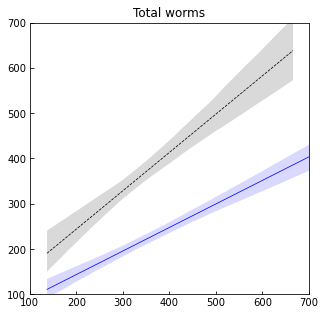

In [37]:
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.regplot(longc['Human'], longc['OWL'], scatter = False,
    fit_reg = True, color = 'blue', line_kws={'linewidth':.75})
ax = sns.regplot(hva['Person1_Count'], hva['Person2_Count'], scatter = False,
    fit_reg = True, color = 'black', line_kws={'linewidth':.75, 'linestyle': '--'})

ax.set_xlabel('')
ax.set_ylabel('')
ax.set(xlim=(100,700), ylim=(100, 700), title='Total worms')
ax.tick_params(axis="both",direction="in")
plt.savefig('C:/Users/Emily/Desktop/NPScreen_figs/HvO_totalwrms.svg')

#### Total Worms: H1 vs H2

In [12]:
h1h2 = pd.DataFrame(list(zip(h1_counts, h2_counts)),
               columns =['H1', 'H2']).dropna()

slope, intercept, r_value, p_value, std_err = linregress(h1h2['H1'], h1h2['H2'])
print(slope, intercept, r_value, p_value, std_err)
rsqrd = print(f"R-squared: {r_value**2:.6f}")

0.8458484000557978 74.73390549191976 0.9097637723875345 6.696076439924178e-08 0.09360945644872014
R-squared: 0.827670


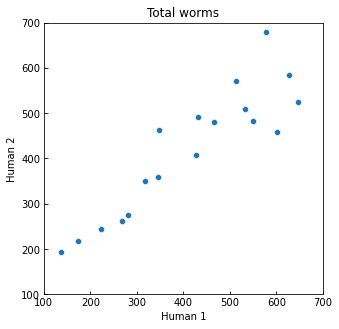

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.scatterplot(data=hva, x="Person1_Count", y="Person2_Count")

ax.set_xlabel('Human 1')
ax.set_ylabel('Human 2')
ax.set(xlim=(100,700), ylim=(100, 700), title='Total worms')
ax.tick_params(axis="both",direction="in")
plt.savefig('C:/Users/Emily/Desktop/NPScreen_figs/HvH_totalwrms.svg')

#### Mean position: H1 vs H2

In [28]:
g = combined.groupby(['FileName', 'Counter']).mean().reset_index()
h1 = g.loc[g['Counter']=='H1']['X']
h2 = g.loc[g['Counter']=='H2']['X']
OWL = g.loc[g['Counter']=='Auto']['X']

xs = pd.DataFrame(list(zip(OWL, h1, h2)),
               columns =['OWL', 'H1', 'H2'])

In [15]:
slope, intercept, r_value, p_value, std_err = linregress(xs['H1'], xs['H2'])
print(slope, intercept, r_value, p_value, std_err)
rsqrd = print(f"R-squared: {r_value**2:.6f}")

0.9964597099691599 -0.08452613285382693 0.9961257883029415 2.15276226628817e-19 0.02133569164122456
R-squared: 0.992267


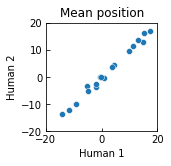

In [16]:
fig, ax = plt.subplots(figsize=(2,2))
ax = sns.scatterplot(data=xs, x='H1', y='H2')

ax.set_xlabel('Human 1')
ax.set_ylabel('Human 2')
ax.set(xlim=(-20,20), ylim=(-20, 20), title='Mean position')
ax.tick_params(axis="both",direction="in")
plt.savefig('C:/Users/Emily/Desktop/NPScreen_figs/HvH_mnX.svg')

#### Mean position: (H1, H2) vs OWL

In [9]:
h1_df = pd.DataFrame(list(zip(OWL, h1)),
               columns =['OWL', 'Human'])

h2_df = pd.DataFrame(list(zip(OWL, h2)),
               columns =['OWL', 'Human'])
long = h1_df.append(h2_df)

slope, intercept, r_value, p_value, std_err = linregress(long['OWL'], long['Human'])
print(slope, intercept, r_value, p_value, std_err)
rsqrd = print(f"R-squared: {r_value**2:.6f}")

NameError: name 'OWL' is not defined

NameError: name 'long' is not defined

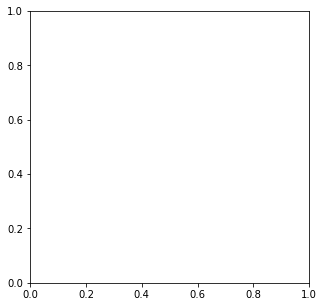

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.regplot(long['Human'], long['OWL'], scatter = False,
    fit_reg = True, color = 'black', line_kws={'linewidth':.75, 'linestyle':'--'})
ax = sns.regplot(xs['H1'], xs['H2'], scatter = False,
    fit_reg = True, color = 'blue', line_kws={'linewidth':.75})
ax.set_xlabel('')
ax.set_ylabel('')
ax.set(xlim=(-22,22), ylim=(-22, 22), title='Mean position')
ax.tick_params(axis="both",direction="in")
plt.savefig('C:/Users/Emily/Desktop/NPScreen_figs/HvO_mnX.svg')

#### Density curves comparing worm locations identified by H1, H2 and OWL

In [76]:
subs = ['loc_S1_005_1C', 'loc_S1_010_2D', 'loc_S1_004_2D', 'loc_S1_004_2B']
subs_df = combined.loc[combined['FileName'].isin(subs)]

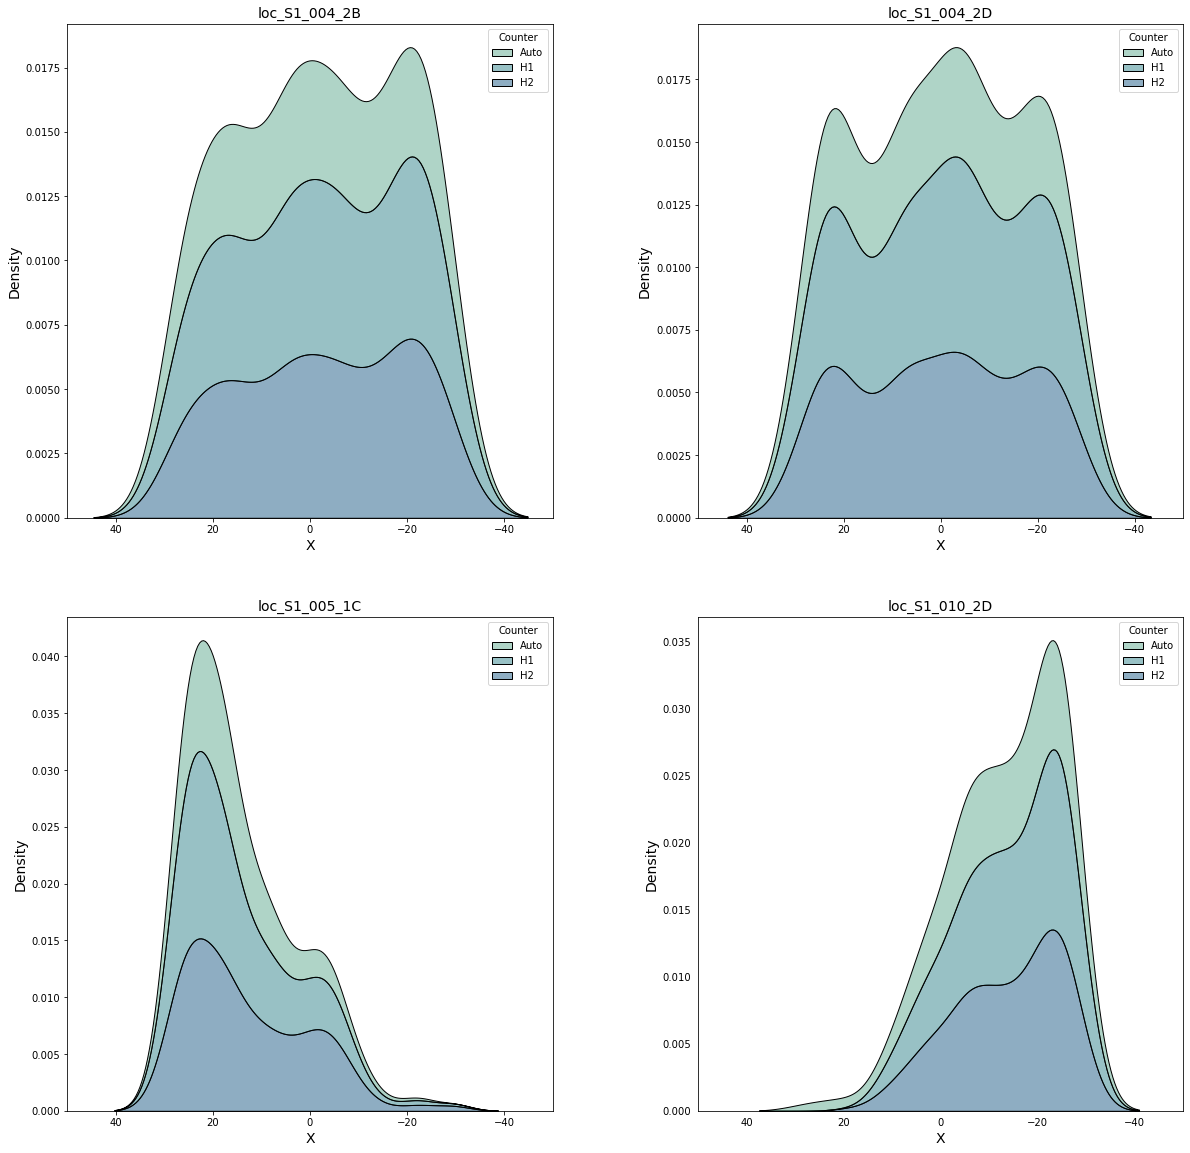

In [57]:
subs_grouped = subs_df.groupby('FileName')

font = {'weight':'normal', 'size':10}


f, ax = plt.subplots(nrows=2, ncols=2,
                        figsize=(20, 20),
                        gridspec_kw={'wspace': 0.30},
                       )
i=0

for n, g in subs_grouped:
    fname = g['FileName'].unique()[0]
    plt.tick_params(left=False, bottom=False)
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('font', **font)

    #sns.displot(data=g, x="X", hue="Counter", kind="kde", label='FileName', fill=True, ax=ax.flat[i])
    sns.kdeplot(data=g, x="X", hue="Counter", fill=True, ax=ax.flat[i], multiple="stack", alpha=.5, palette="crest").set(title = fname, 
                xlim = (50,-50))
    i += 1

    plt.rcParams['svg.fonttype'] = 'none'

plt.savefig('C:/Users/Emily/Desktop/UL_analysis/subset_hva.svg')

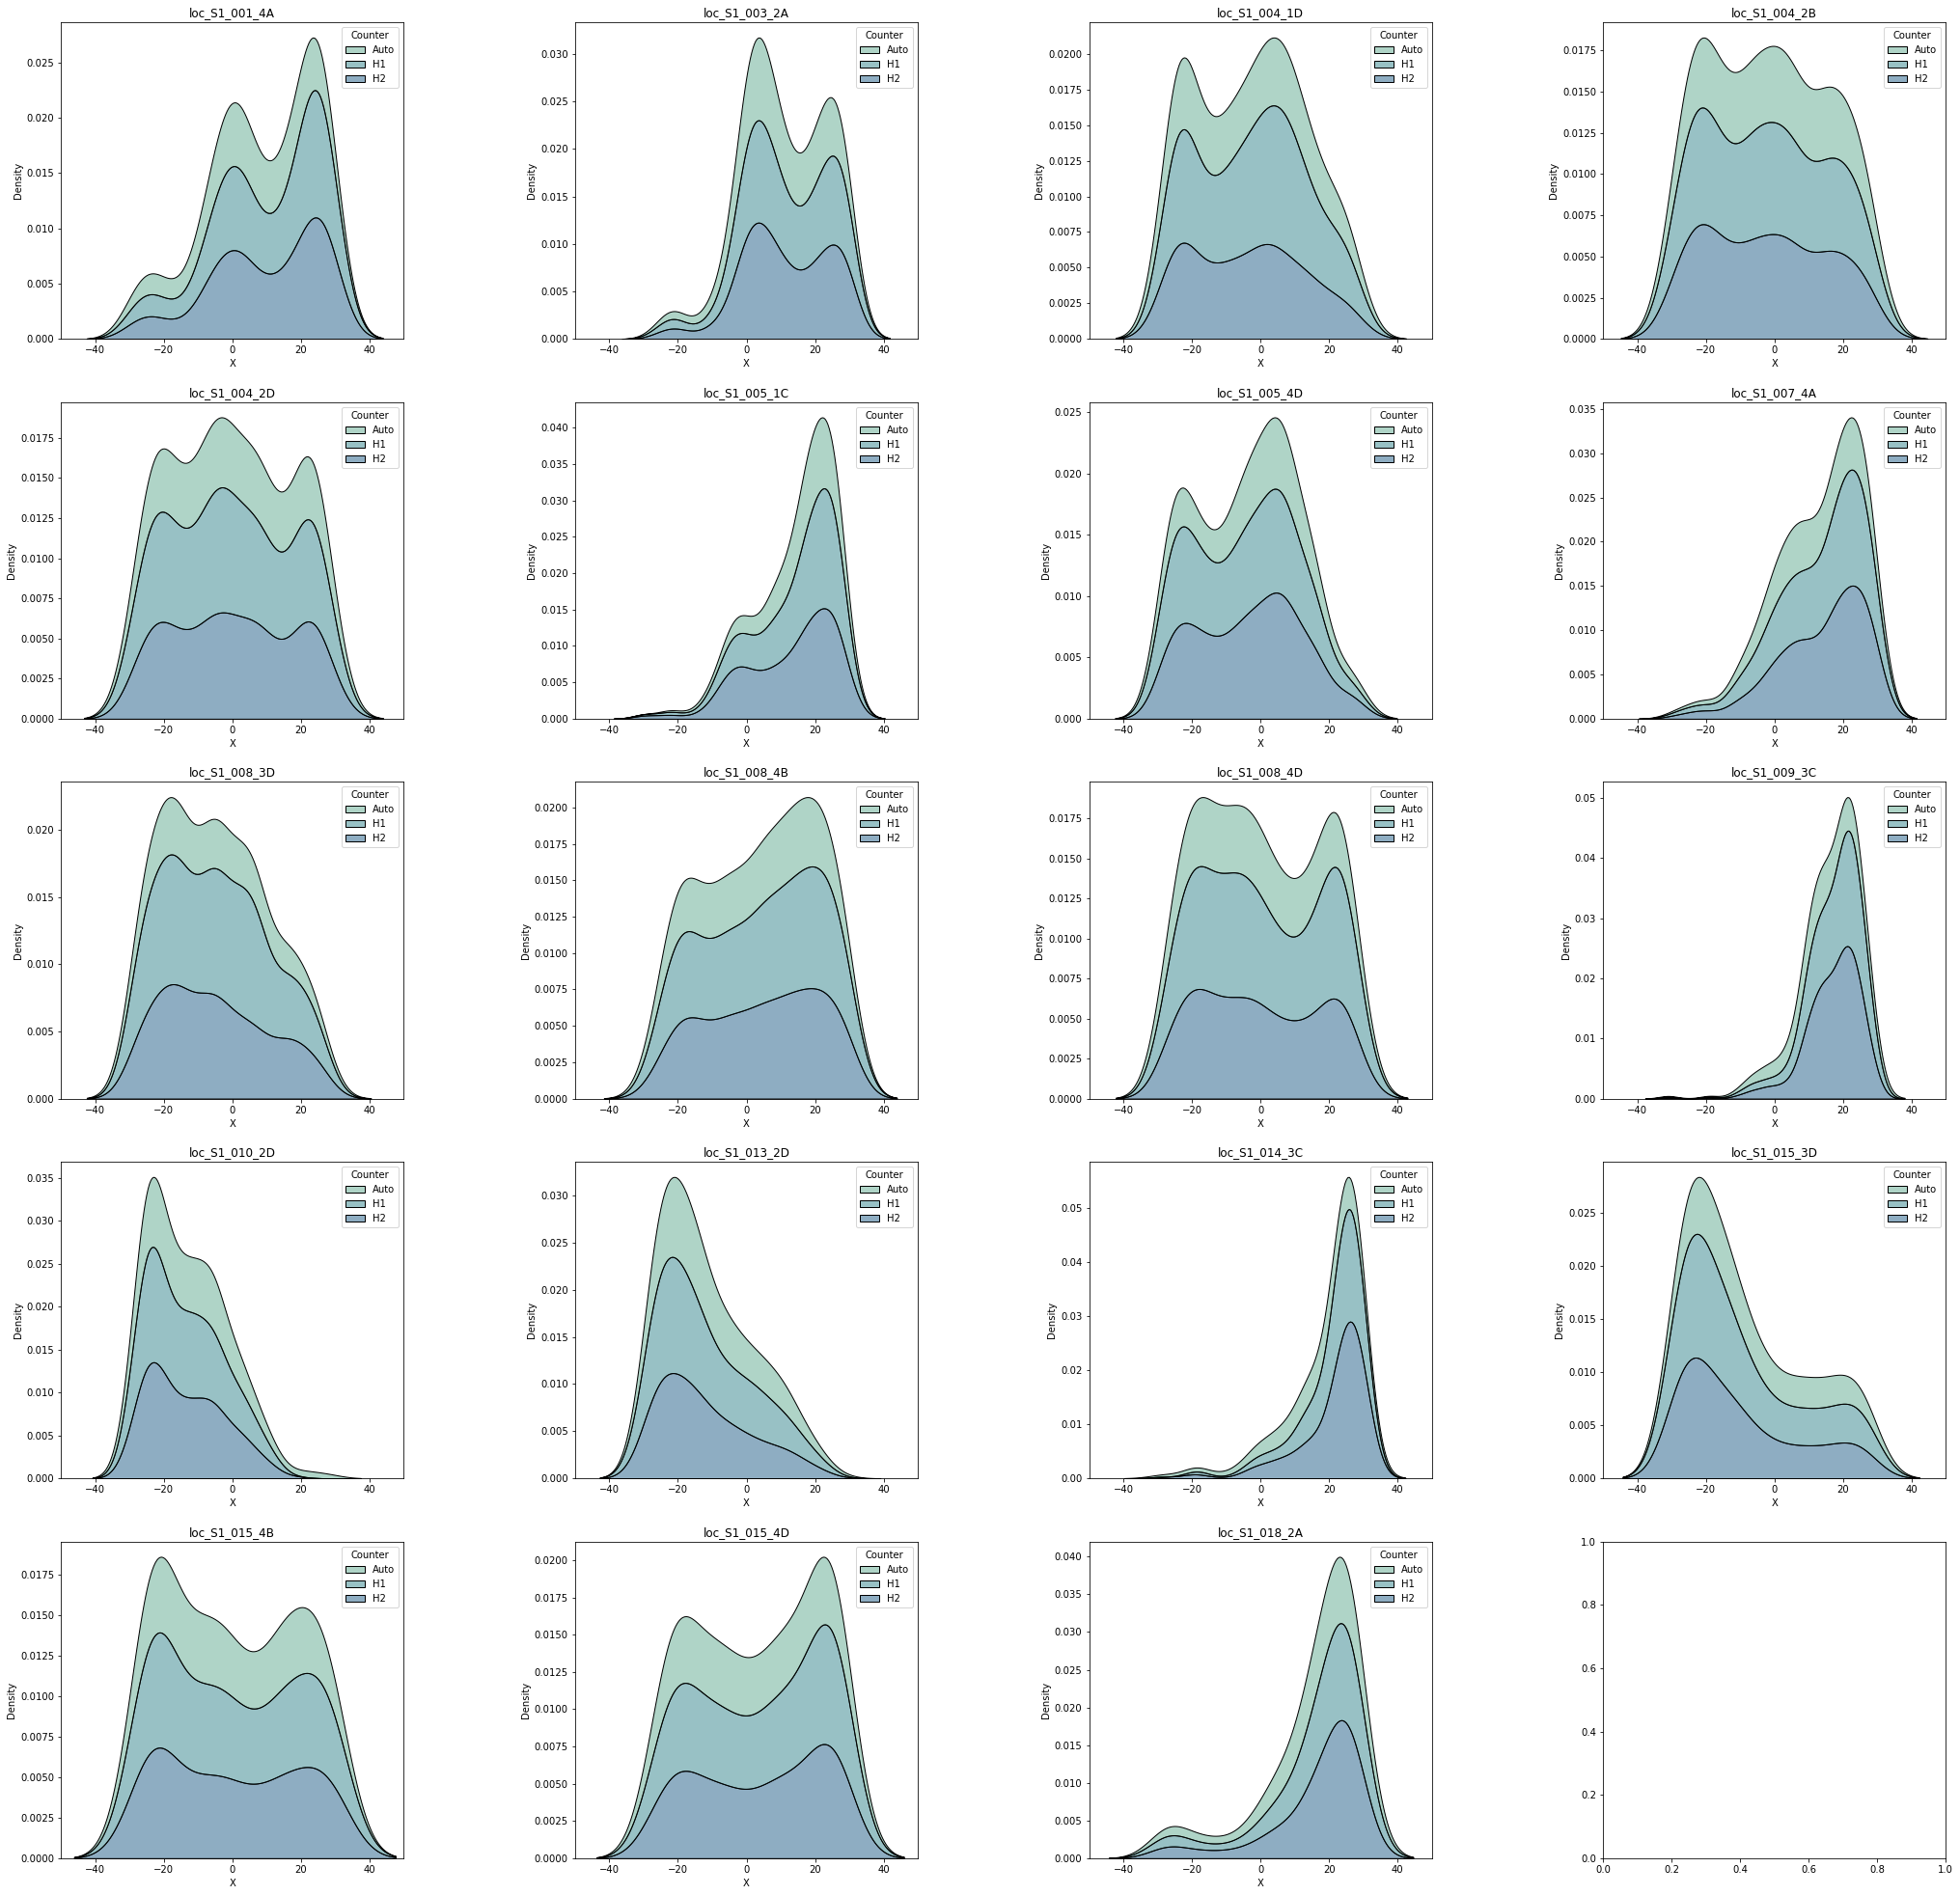

In [225]:
f, ax = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50}
                       )
i=0
for n, g in gcomb:
    fname = g['FileName'].unique()[0]
    #sns.displot(data=g, x="X", hue="Counter", kind="kde", label='FileName', fill=True, ax=ax.flat[i])
    sns.kdeplot(data=g, x="X", hue="Counter", fill=True, ax=ax.flat[i], multiple="stack", alpha=.5, palette="crest").set(title = fname,
    xlim = (-50,50))
    i += 1
    
plt.savefig('C:/Users/Emily/Desktop/UL_analysis/corrected_comparison.png', dpi=300)

In [5]:
types = ['H1', 'H2']
cohend_df = pd.DataFrame()
for n, g in gcomb:
    analysis = dabest.load(g, idx=("Auto", "H1", "H2"), x="Counter", y="X")
    ad = analysis.cohens_d.statistical_tests
    #ad.cohens_d.plot()
    
    ad['FileName'] = n
    
    auto = g.loc[g['Counter'] == 'Auto']['X']
    for t in types:
        if t == 'H1' :
            h1 = g.loc[g['Counter'] == 'H1']['X']
            cohens_d = -(mean(auto) - mean(h1)) / (sqrt((stdev(auto) ** 2 + stdev(h1) ** 2) / 2))
            ad.loc[ad['test'] =='H1', ['Cohens_d']] = cohens_d

        elif t == 'H2':
            h2 = g.loc[g['Counter'] == 'H2']['X']
            cohens_d = -(mean(auto) - mean(h2)) / (sqrt((stdev(auto) ** 2 + stdev(h2) ** 2) / 2))
            ad.loc[ad['test'] =='H2', ['Cohens_d']] = cohens_d
        
    cohend_df = cohend_df.append(ad, ignore_index = True)

print(len(cohend_df))

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

38


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [227]:
cohend_df.to_csv('C:/Users/Emily/Desktop/UL_analysis/cohens_d.csv')

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=cohend_df, x="Cohens_d", y="difference", hue="test", style="test")
ax.set_xlabel('Cohen\'s D')
ax.set_ylabel('Bootstrapped Cohen\'s D')
ax.set(ylim=(-.5,1), xlim=(-.5,1), title='Cohen\'s D, measuring effect size')
#plt.savefig('C:/Users/Emily/Desktop/UL_analysis/comparing_cds.png', dpi=300)

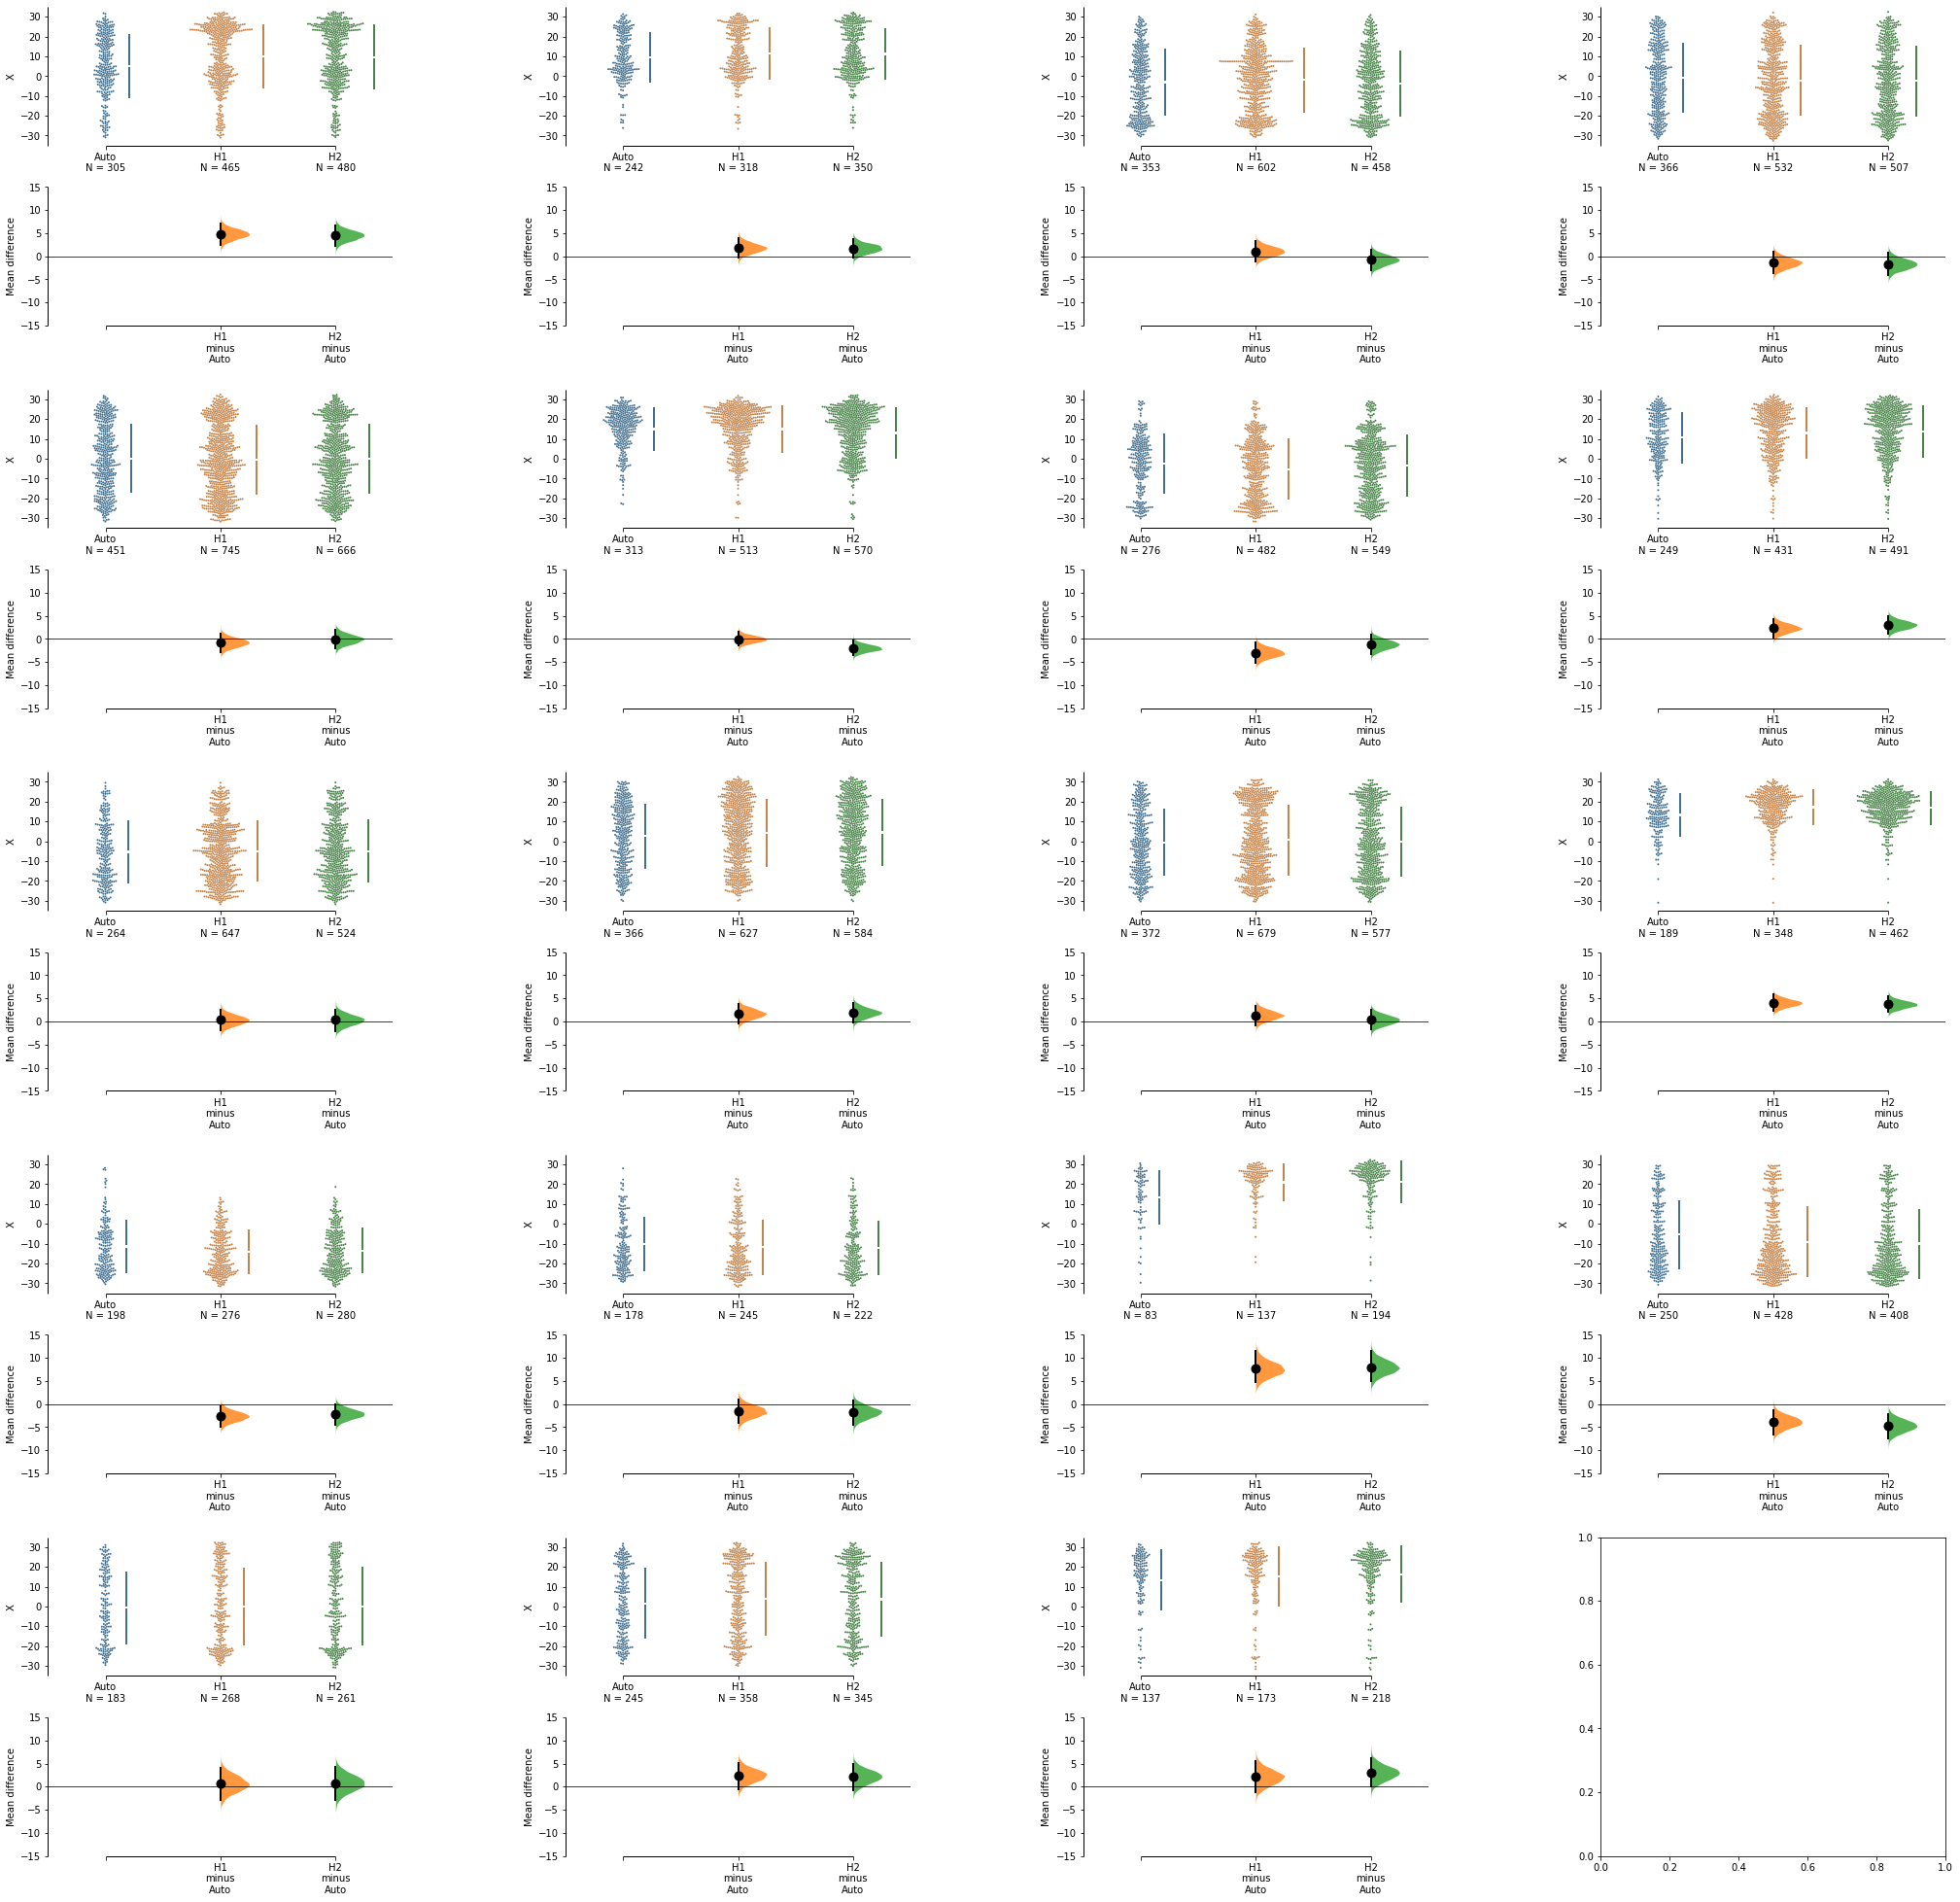

In [7]:
f, axx = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50} # ensure proper width-wise spacing.
                       )
i=0
for n, g in gcomb:
    fname = g['FileName'].unique()[0]
    multi = dabest.load(g, idx=(("Auto", "H1", "H2")), x="Counter", y="X")
    multi.mean_diff.plot(ax=axx.flat[i], raw_marker_size=2, contrast_ylim=(-15,15), swarm_ylim=(-35,35))
    i += 1
#plt.savefig('C:/Users/Emily/Desktop/UL_analysis/UL_mean_diff.png', dpi=300)

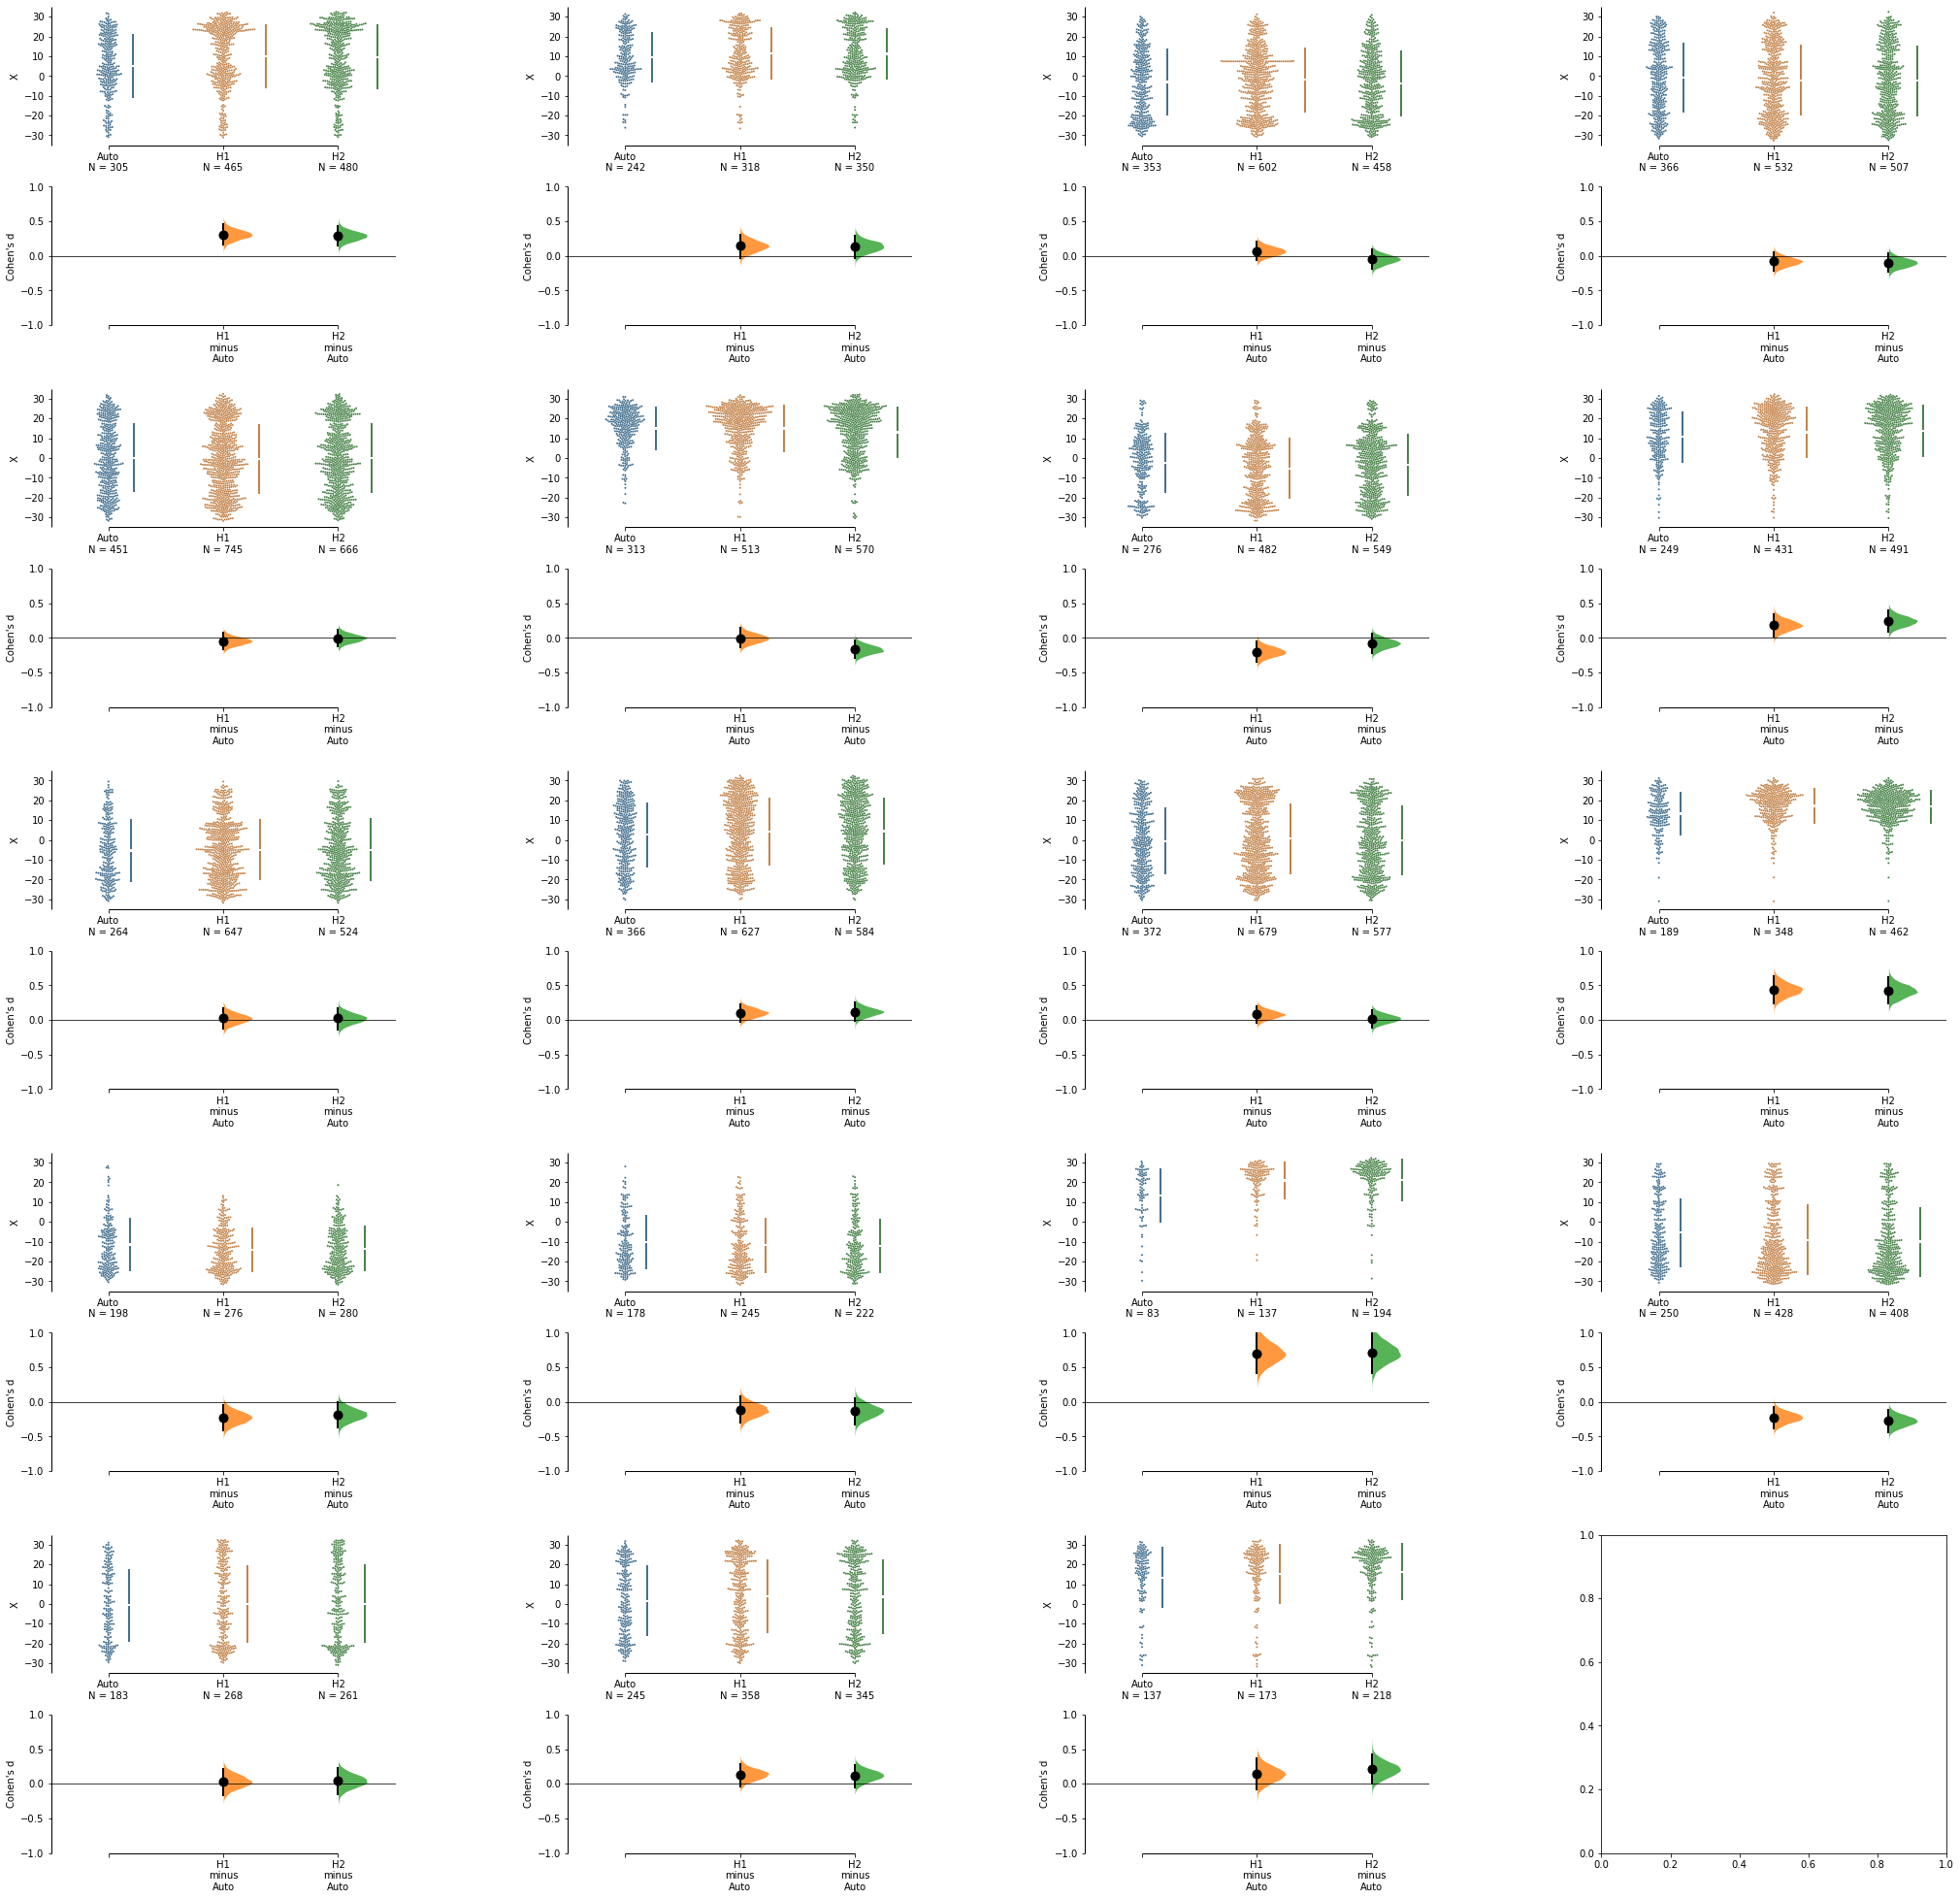

In [134]:
f, axx = plt.subplots(nrows=5, ncols=4,
                        figsize=(35, 35),
                        gridspec_kw={'wspace': 0.50} # ensure proper width-wise spacing.
                       )
i=0
for n, g in gcomb:
    multi = dabest.load(g, idx=(("Auto", "H1", "H2")), x="Counter", y="X")
    multi.cohens_d.plot(ax=axx.flat[i], raw_marker_size=2, contrast_ylim=(-1,1), swarm_ylim=(-35,35))
    i += 1

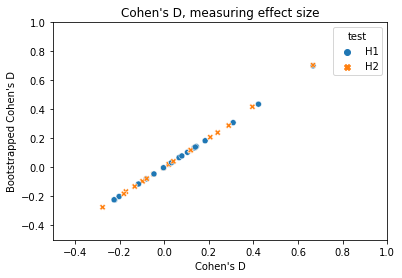

In [246]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=cohend_df, x="Cohens_d", y="difference", hue="test", style="test")
ax.set_xlabel('Cohen\'s D')
ax.set_ylabel('Bootstrapped Cohen\'s D')
ax.set(ylim=(-.5,1), xlim=(-.5,1), title='Cohen\'s D, measuring effect size')
plt.savefig('C:/Users/Emily/Desktop/UL_analysis/comparing_cds.png', dpi=300)

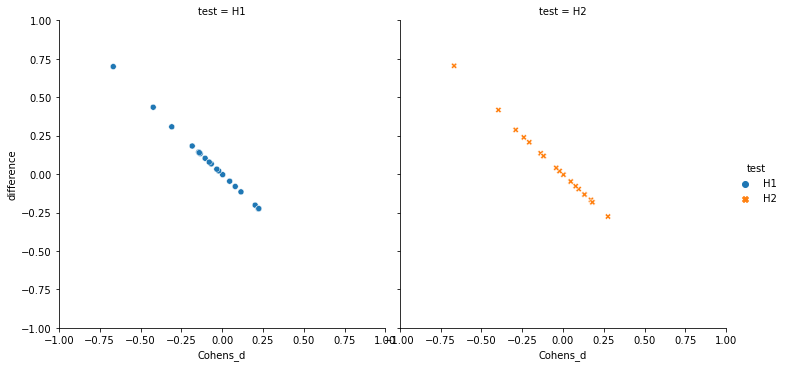

In [121]:
p = sns.relplot(
    data=cohend_df, x="Cohens_d", y="difference",
    col="test", hue="test", style="test",
    kind="scatter"
)
p.set(ylim=(-1, 1), xlim=(-1,1))